# Importing

In [226]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
import warnings


# Pre Processing

In [227]:
data = pd.read_csv('spam_dataset.csv')

X = data['text']  # Features - the email text
y = data['label_num']  # Target variable - spam or not spam

# Vectorize text
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
x_vectorized = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(x_vectorized, y, test_size=0.2, random_state=42)
    


# Default Model (No modified Parameters)

In [228]:
# Example of a basic logistic regression model

basic_model = XGBClassifier()
basic_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Tune Model


In [229]:
# 10 minutes runtime

# Filter out the UserWarning related to dimension inference
warnings.filterwarnings("ignore", message="Dimension .* was inferred to .* In upcoming versions of scikit-optimize")

xgb_param_space = {
    'learning_rate': (0.01, 0.5),
    'max_depth': (5, 8),
    'subsample': (0.25, 1),
    'colsample_bytree': (0.01, 0.25), 
    'reg_alpha': (0.25, 0.75),
    'reg_lambda': (0.25, 0.75),
    'n_estimators': (100, 350)
}

# Create XGBoost classifier
xgb = XGBClassifier()

# Perform Bayesian Optimization for XGBoost
xgb_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=xgb_param_space,
    n_iter=50,  # Number of parameter settings that are sampled.
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    # verbose=10,
    random_state=42
)

# Fit the model
xgb_search.fit(X_train, y_train)


BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=None, ...),
              n_jobs=-1, random_state=42, scoring='accuracy',
              search_spaces={'colsample_bytree': (0.01, 0.25),
                             'learning_rate': (0.01, 0.5), 'max_depth': (5, 8),
                             'n_estimators': (100, 350),
                             'reg_alpha': (0.25, 0.75),
                             'reg_lambda': (0.25, 0.75),
                             'subsample': (0.25, 1)})

# Train and Visualize Model

Best hyperparameters for XGBoost:
colsample_bytree: 0.0159
learning_rate: 0.1418
max_depth: 8.0000
n_estimators: 328.0000
reg_alpha: 0.5626
reg_lambda: 0.2516
subsample: 0.9880


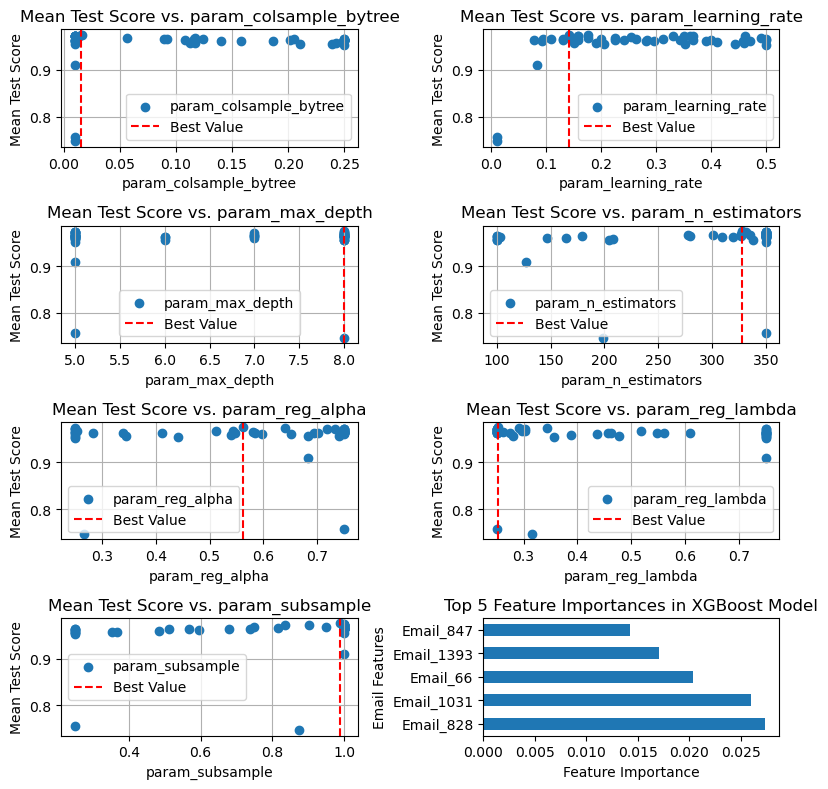

In [230]:
# Get the best hyperparameters for XGBoost
best_params_xgb = xgb_search.best_params_

# Train XGBoost with the best hyperparameters
xgb_best = XGBClassifier(**best_params_xgb)
xgb_best.fit(X_train, y_train)

print("Best hyperparameters for XGBoost:")
for param, value in best_params_xgb.items():
    print(f"{param}: {value:.4f}")

# Convert cv_results_ to DataFrame
cv_results_df = pd.DataFrame(xgb_search.cv_results_)

# Extract relevant columns except 'max_depth'
# param_columns = [col for col in cv_results_df.columns if col.startswith("param_") and col != "param_max_depth"]
param_columns = [col for col in cv_results_df.columns if col.startswith("param_")]
mean_test_score = cv_results_df["mean_test_score"]

# Plot the data for each hyperparameter separately
fig, axes = plt.subplots(4, 2, figsize=(8, 8))

for i, param_col in enumerate(param_columns):
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    # ax.plot(cv_results_df[param_col], mean_test_score, marker='o', label=param_col)
    ax.scatter(cv_results_df[param_col], mean_test_score, label=param_col)
    
    # Highlight the best value
    best_index = cv_results_df["mean_test_score"].idxmax()
    best_value = cv_results_df[param_col][best_index]
    ax.axvline(x=best_value, color='r', linestyle='--', label='Best Value')

    ax.set_xlabel(param_col)
    ax.set_ylabel("Mean Test Score")
    ax.set_title("Mean Test Score vs. " + param_col)
    ax.legend()
    ax.grid(True)

temp_index = [f"Email_{i}" for i in range(len(xgb_best.feature_importances_))]
feat_importances = pd.Series(xgb_best.feature_importances_, index=temp_index)
feat_importances.nlargest(5).plot(kind='barh', ax=axes[-1, -1])
axes[-1, -1].set_xlabel('Feature Importance')
axes[-1, -1].set_ylabel('Email Features')
axes[-1, -1].set_title('Top 5 Feature Importances in XGBoost Model')

plt.tight_layout()
plt.show()



# Test and Evaluate Model

In [231]:
# Default Model:
basic_model_pred = basic_model.predict(X_test)

# # Calculate accuracy for the basic Logistic Regression model
basic_model_accuracy = accuracy_score(y_test, basic_model_pred)
print(f"Basic XG Boost Accuracy: {basic_model_accuracy:.4f}")

# Tuned Model:
best_model_pred = xgb_best.predict(X_test)

# Calculate accuracy for the tuned Logistic Regression model
best_model_accuracy = accuracy_score(y_test, best_model_pred)
print(f"Tuned XG Boost Accuracy: {best_model_accuracy:.4f}")

# Show improvement
print("\nImprovement in accuracy:")
print(f"XG Boost: {best_model_accuracy - basic_model_accuracy:.4f}")


Basic XG Boost Accuracy: 0.9739
Tuned XG Boost Accuracy: 0.9816

Improvement in accuracy:
XG Boost: 0.0077
